In [1]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
file_path = '/content/scrape_duration_seconds.csv'  # Replace this with your file path
df_calls_total = pd.read_csv(file_path, low_memory=False)

# Display the first few rows to verify the data is loaded correctly
df_calls_total.head()

# Display the number of NaN values in each column
print("NaN values in each column before treatment:")
print(df_calls_total.isna().sum())

# Convert data types to best possible types
df_converted = df_calls_total.convert_dtypes()

# Select only numeric columns for interpolation
numeric_cols = df_converted.select_dtypes(include=['number']).columns

# Convert mixed-type columns to numeric, coercing errors to NaN
for col in numeric_cols:
    df_converted[col] = pd.to_numeric(df_converted[col], errors='coerce')

# Convert IntegerArray columns to float64
# This ensures compatibility with the interpolate method
for col in numeric_cols:
    if isinstance(df_converted[col].dtype, pd.Int64Dtype): # Check for Int64Dtype instead of Float64Dtype
        df_converted[col] = df_converted[col].astype('float64')

# Convert FloatingArray columns to float64
for col in numeric_cols:
    if isinstance(df_converted[col].dtype, pd.Float64Dtype):
        df_converted[col] = df_converted[col].astype('float64')

# Perform interpolation on numeric columns only
df_converted[numeric_cols] = df_converted[numeric_cols].interpolate()

# Check for any remaining NaN values after interpolation
print("NaN values after interpolation:")
print(df_converted.isna().sum())

# Backward Fill to fill any remaining NaN values
df_bfill = df_converted.bfill()

# Check for any remaining NaN values after backward fill
print("NaN values after backward fill:")
print(df_bfill.isna().sum())

# Forward Fill to handle any remaining NaN values
df_ffill = df_bfill.ffill()

# Check for any remaining NaN values after forward fill
print("NaN values after forward fill:")
print(df_ffill.isna().sum())

# Creating the final DataFrame
final_df = df_ffill

# Display the first few rows of the final DataFrame
final_df.head()

NaN values in each column before treatment:
Time        0
Value       0
instance    0
job         0
dtype: int64
NaN values after interpolation:
Time        0
Value       0
instance    0
job         0
dtype: int64
NaN values after backward fill:
Time        0
Value       0
instance    0
job         0
dtype: int64
NaN values after forward fill:
Time        0
Value       0
instance    0
job         0
dtype: int64


,Time,Value,instance,job
0,2024-08-13 12:30:00,0.000238,otel-collector:8889,aggregated-trace-metrics
1,2024-08-13 13:00:00,0.000215,otel-collector:8889,aggregated-trace-metrics
2,2024-08-13 13:30:00,0.000244,otel-collector:8889,aggregated-trace-metrics
3,2024-08-13 14:00:00,0.000547,otel-collector:8889,aggregated-trace-metrics
4,2024-08-13 14:30:00,0.000089,otel-collector:8889,aggregated-trace-metrics


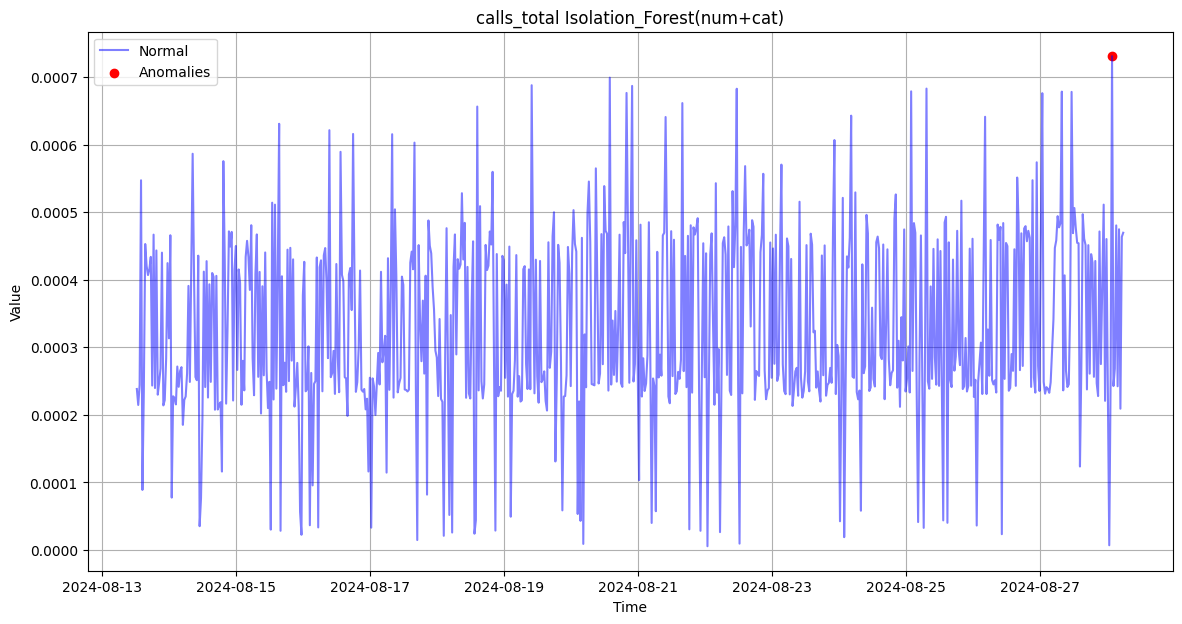

Number of anomalies detected: 1
                   Time     Value             instance  \
699 2024-08-28 02:00:00  0.000731  otel-collector:8889   

                          job  anomaly  
699  aggregated-trace-metrics       -1  


In [3]:
#model with numerical and categorical anomalies (isolation_forest)

#DATA PROCESSING-----------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from scipy.sparse import csr_matrix # Import csr_matrix

# Selecting the numerical and categorical columns
numerical_columns = ['Value']
categorical_columns = ['instance', 'job']

# Preprocessing: Scaling numerical data and encoding categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)]) # Set sparse_output to False in OneHotEncoder

# Creating the Isolation Forest model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', IsolationForest(contamination=0.001, random_state=42))])

# Fit the model
model.fit(final_df)

# Predict anomalies (anomalies will be labeled as -1, normal as 1)
final_df['anomaly'] = model.fit_predict(final_df)

# Filter the anomalies
anomalies = final_df[final_df['anomaly'] == -1]

# Display the detected anomalies
anomalies

# PLOT THE ANOMALY
import matplotlib.pyplot as plt

# Convert 'Time' to datetime format
final_df['Time'] = pd.to_datetime(final_df['Time'])

# Plotting the time series data with anomalies
plt.figure(figsize=(14, 7))

# Plot all data points
plt.plot(final_df['Time'], final_df['Value'], label='Normal', color='blue', alpha=0.5)

# Highlight the anomalies
anomalies = final_df[final_df['anomaly'] == -1]
plt.scatter(anomalies['Time'], anomalies['Value'], color='red', label='Anomalies')

# Adding labels and title
plt.title('calls_total Isolation_Forest(num+cat)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.grid(True)
plt.show()
print(f"Number of anomalies detected: {len(anomalies)}")
print(anomalies.head())

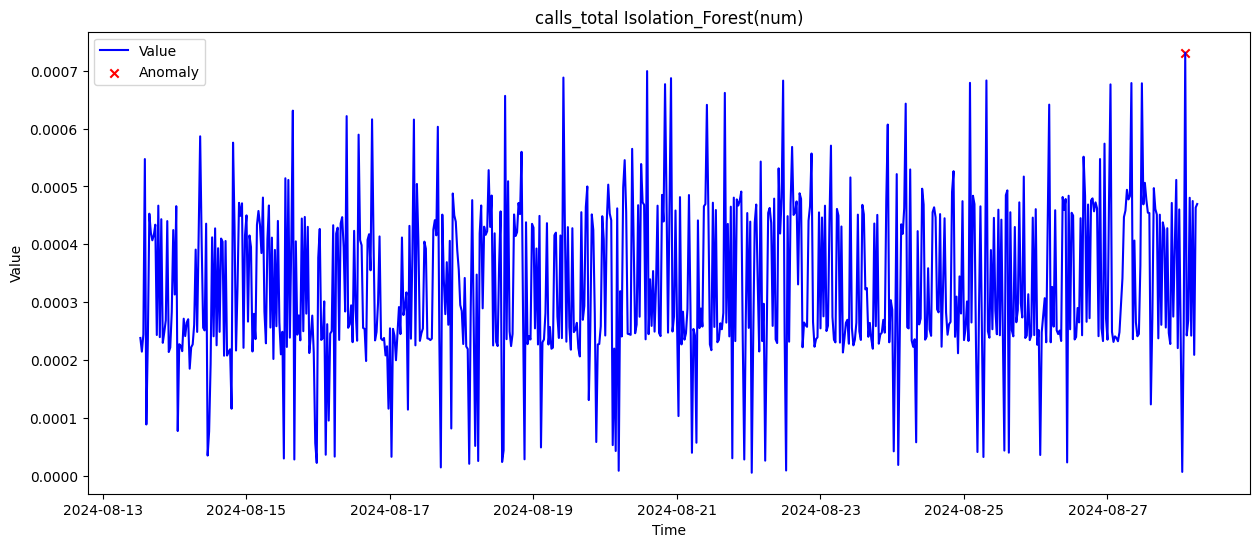

Number of anomalies detected: 1
                        Value             instance                       job  \
Time                                                                           
2024-08-28 02:00:00  0.000731  otel-collector:8889  aggregated-trace-metrics   

                     anomaly  
Time                          
2024-08-28 02:00:00       -1  


In [4]:
#model with only numerical anomalies (isolation_forest)

# Convert 'Time' column to datetime and set as index
final_df['Time'] = pd.to_datetime(final_df['Time'])
final_df.set_index('Time', inplace=True)

# Select all relevant numeric metric columns for anomaly detection
metrics_columns = ['Value']  # Add other metric columns as needed
metrics_data = final_df[metrics_columns]

# Standardize the data
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_data)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)

# Fit the model and predict anomalies (-1 means anomaly, 1 means normal)
final_df['anomaly'] = iso_forest.fit_predict(metrics_scaled)

# Visualize the anomalies for each metric
for column in metrics_columns:
    plt.figure(figsize=(15, 6))
    plt.plot(final_df.index, final_df[column], label=column, color='blue')
    plt.scatter(final_df.index[final_df['anomaly'] == -1], final_df[column][final_df['anomaly'] == -1],
                color='red', label='Anomaly', marker='x')
    plt.title(f'calls_total Isolation_Forest(num)')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Print out the anomalies
anomalies = final_df[final_df['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")
print(anomalies.head())

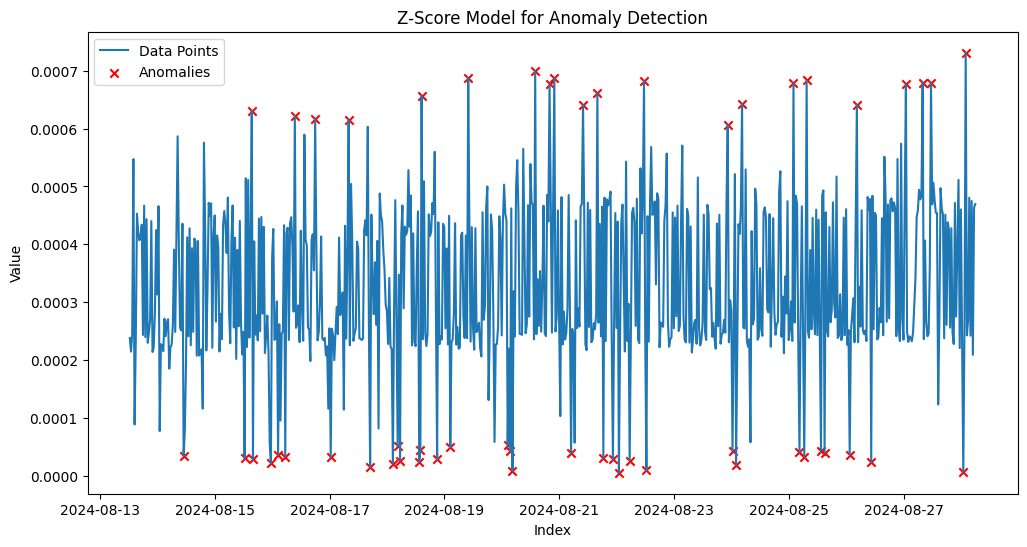

Number of anomalies detected: 54
                        Value             instance                       job  \
Time                                                                           
2024-08-14 11:00:00  0.000035  otel-collector:8889  aggregated-trace-metrics   
2024-08-15 12:30:00  0.000030  otel-collector:8889  aggregated-trace-metrics   
2024-08-15 15:30:00  0.000631  otel-collector:8889  aggregated-trace-metrics   
2024-08-15 16:00:00  0.000028  otel-collector:8889  aggregated-trace-metrics   
2024-08-15 23:30:00  0.000022  otel-collector:8889  aggregated-trace-metrics   
2024-08-16 02:30:00  0.000037  otel-collector:8889  aggregated-trace-metrics   
2024-08-16 05:30:00  0.000033  otel-collector:8889  aggregated-trace-metrics   
2024-08-16 09:30:00  0.000622  otel-collector:8889  aggregated-trace-metrics   
2024-08-16 18:00:00  0.000616  otel-collector:8889  aggregated-trace-metrics   
2024-08-17 00:30:00  0.000033  otel-collector:8889  aggregated-trace-metrics   
2024-08

In [9]:
#Z_Score

import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'final_df' already loaded with a 'Value' column
# Calculate the z-scores for the "Value" column
final_df['Value_zscore'] = zscore(final_df['Value'])

# Set a threshold for anomaly detection (3 standard deviations is typical, but you have set 0.1)
threshold = 2

# Flag anomalies: True for anomalies, False otherwise
final_df['Anomaly'] = final_df['Value_zscore'].abs() > threshold

# Extract anomalies for further analysis or display
anomalies = final_df[final_df['Anomaly']]

# Plotting the data points and highlighting anomalies
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Value'], label='Data Points')
plt.scatter(anomalies.index, anomalies['Value'], color='red', label='Anomalies', marker='x')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Z-Score Model for Anomaly Detection')
plt.legend()
plt.show()

# Output the number of anomalies detected
print(f"Number of anomalies detected: {len(anomalies)}")

# Optionally, display the anomalies DataFrame if you want to see the actual anomalous values
# If you intended to use a custom module, install it first using pip:
# !pip install ace_tools
# Then uncomment the line below
# import ace_tools as tools; tools.display_dataframe_to_user(name="Anomalies", dataframe=anomalies)

# If you just want to display the dataframe, use:
print(anomalies)

Number of anomalies detected: 0


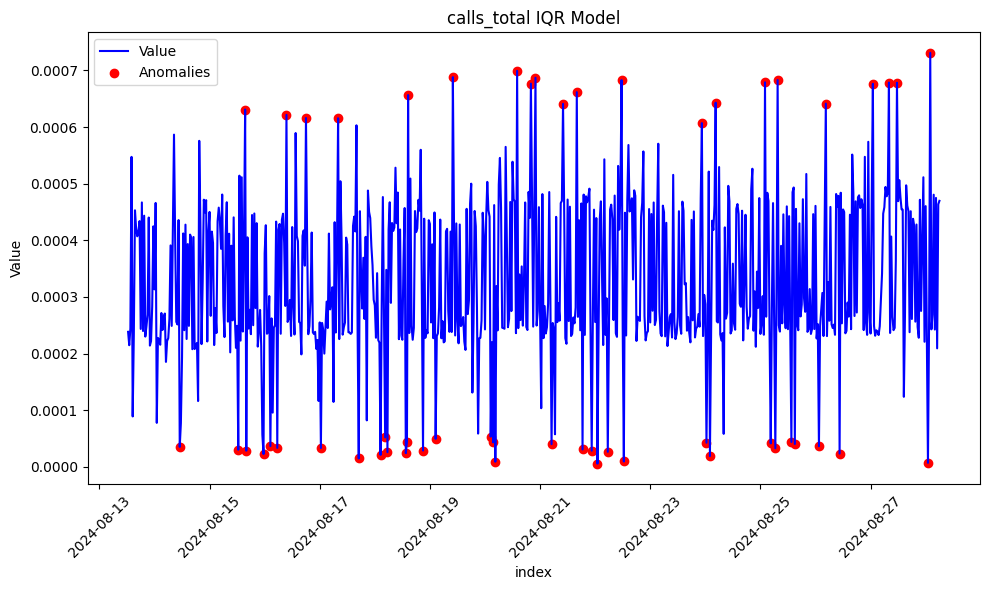

In [12]:
#IQR

import matplotlib.pyplot as plt

# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile) for the 'Value' column
Q1 = final_df['Value'].quantile(0.25)
Q3 = final_df['Value'].quantile(0.75)

# Step 2: Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Step 3: Define the lower and upper bounds for anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Identify anomalies
anomalies = final_df[(final_df['Value'] < lower_bound) | (final_df['Value'] > upper_bound)]

print(f"Number of anomalies detected: {len(anomalies)}")

# Step 5: Plotting the graph without converting 'Time' to datetime
plt.figure(figsize=(10, 6))

# Plot all values
plt.plot(final_df.index, final_df['Value'], label='Value', color='blue')

# Highlight anomalies
plt.scatter(final_df[final_df['Anomaly']].index, final_df[final_df['Anomaly']]['Value'], color='red', label='Anomalies')

# Adding titles and labels
plt.title('calls_total IQR Model')
plt.xlabel('index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



Number of anomalies detected: 109


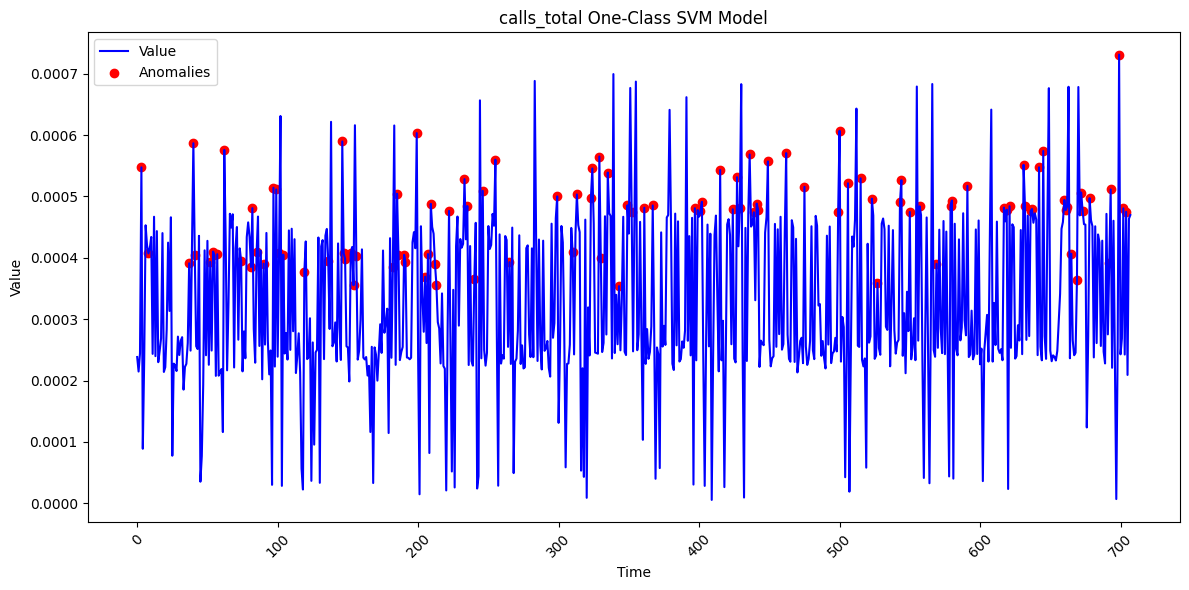

In [16]:
#One-Class SVM Model

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = '/content/scrape_duration_seconds.csv'
final_df = pd.read_csv(file_path)

# Strip any leading/trailing spaces from column names
final_df.columns = final_df.columns.str.strip()

# Select the numerical feature for One-Class SVM (e.g., 'Value')
X = final_df[['Value']]

# Standardize the feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.0001)  # You can adjust the parameters based on your needs
ocsvm.fit(X_scaled)

# Predict anomalies (1 for normal, -1 for anomaly)
final_df['anomaly'] = ocsvm.predict(X_scaled)

# Display the first few rows with the anomaly column
# Use .reset_index() to make 'Time' a column again
final_df.reset_index()[['Time', 'Value', 'anomaly']].head()

# Convert the 'Time' column to datetime format if not already
# final_df['Time'] = pd.to_datetime(final_df['Time'])

# Plot the values over time
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Value'], label='Value', color='blue')

# Highlight anomalies
anomalies = final_df[final_df['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['Value'], color='red', label='Anomalies')

print(f"Number of anomalies detected: {len(anomalies)}")

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('calls_total One-Class SVM Model')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

                  Time     Value  LOF_Score  Outlier
0  2024-08-13 12:30:00  0.000238          1    False
1  2024-08-13 13:00:00  0.000215          1    False
2  2024-08-13 13:30:00  0.000244          1    False
3  2024-08-13 14:00:00  0.000547          1    False
4  2024-08-13 14:30:00  0.000089         -1     True
Number of anomalies detected: 71


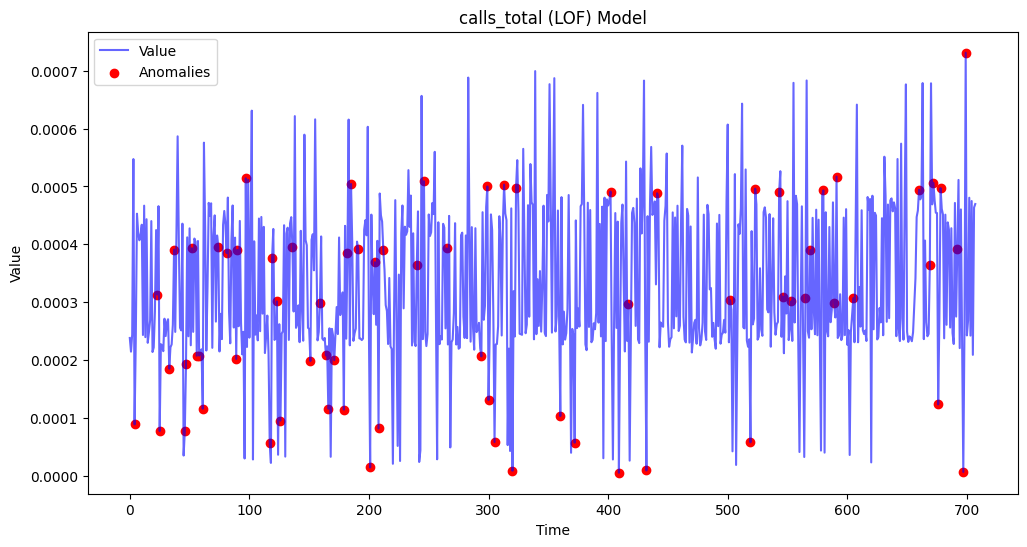

In [15]:
# LOF Model

from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

# Load the dataset
final_df = pd.read_csv('/content/scrape_duration_seconds.csv')  # Use the correct path to your CSV

# Extract the 'Value' column for LOF analysis
X = final_df[['Value']].values

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust parameters as needed
final_df['LOF_Score'] = lof.fit_predict(X)

# Add a column to indicate if a point is an outlier (-1) or not (1)
final_df['Outlier'] = final_df['LOF_Score'] == -1

# Reset the index to make 'Time' a column again
final_df = final_df.reset_index()

# Display the dataframe with LOF scores and outlier labels
print(final_df[['Time', 'Value', 'LOF_Score', 'Outlier']].head())

import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Value'], label='Value', color='blue',  alpha=0.6)

# Highlight anomalies
anomalies = final_df[final_df['Outlier'] == True]
plt.scatter(anomalies.index, anomalies['Value'], color='red', label='Anomalies')

print(f"Number of anomalies detected: {len(anomalies)}")

# Adding labels and title
plt.title('calls_total (LOF) Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


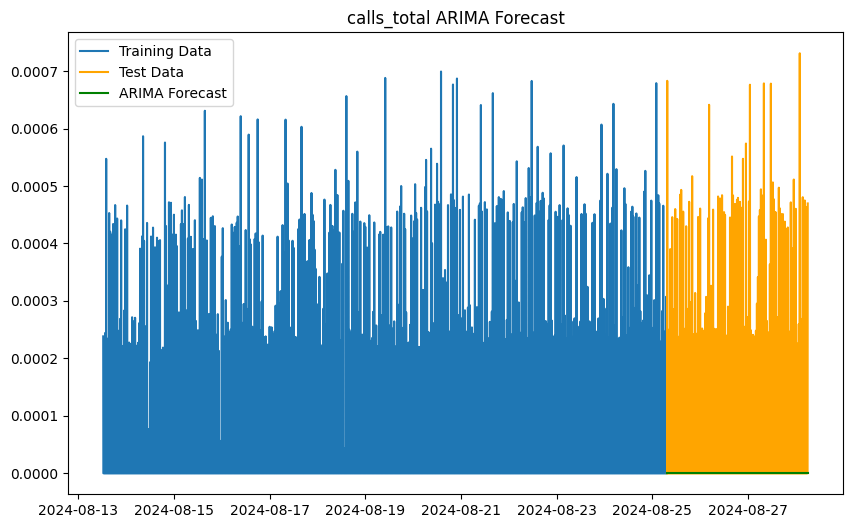

In [20]:
#ARIMA Model

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = '/content/scrape_duration_seconds.csv'
df = pd.read_csv(file_path)

# Step 2: Parse the 'Time' column as datetime and set it as the index
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

# Step 3: Resample the data by summing the 'Value' column every 15 minutes to handle any irregular intervals
df_resampled = df['Value'].resample('5T').sum()

# Step 4: Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled[:train_size], df_resampled[train_size:]

# Step 5: Fit the ARIMA model on the training data
# We'll use a basic ARIMA model with (p, d, q) = (1, 1, 1) as a starting point.
model = ARIMA(train, order=(0, 1, 0))
# model = ARIMA(train, order=(1, 1, 0))
# model = ARIMA(train, order=(0, 0, 1))
arima_result = model.fit()

# Step 6: Forecast on the test data
forecast = arima_result.forecast(steps=len(test))

# Step 7: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.legend()
plt.title('calls_total ARIMA Forecast')
plt.show()


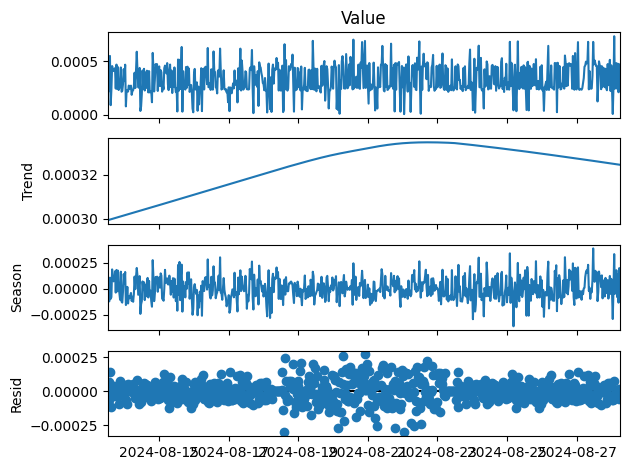

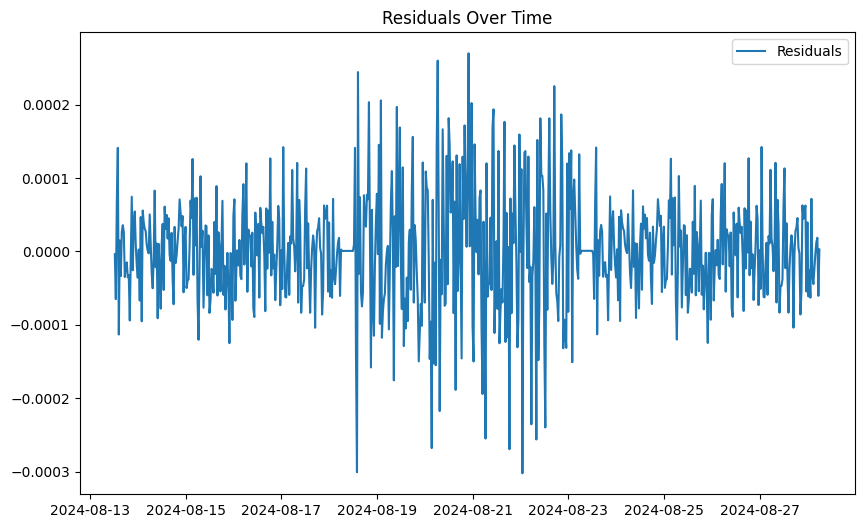

In [21]:
#Seasonal Decomposition of Time Series (STL)

import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load the dataset
file_path = '/content/scrape_duration_seconds.csv'
df = pd.read_csv(file_path)

# Convert 'Time' column to datetime and set it as the index
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

# Assuming data points are collected every 15 seconds in a 1-hour period
period = 240  # 4 data points per minute * 60 minutes = 240 data points per hour

# Perform STL decomposition with the specified period
stl = STL(df['Value'], period=period)
result = stl.fit()

# Plot the decomposed components
result.plot()
plt.show()

# Extract residuals from STL decomposition
residuals = result.resid

# 1. Plot the residuals over time
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1553 - val_loss: 0.0526
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0435 - val_loss: 0.0402
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0427 - val_loss: 0.0414
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0387 - val_loss: 0.0373
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0400 - val_loss: 0.0401
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0373 - val_loss: 0.0371
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0367 - val_loss: 0.0367
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0373 - val_loss: 0.0368
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0397 - val_loss: 0.0389
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0361 - val_loss: 0.0368
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Predictions: [0.00031513 0.00031245 0.00031789 0.00032639 0.00032939]
Actual Values: [0.00023876 0.00039018 0.0

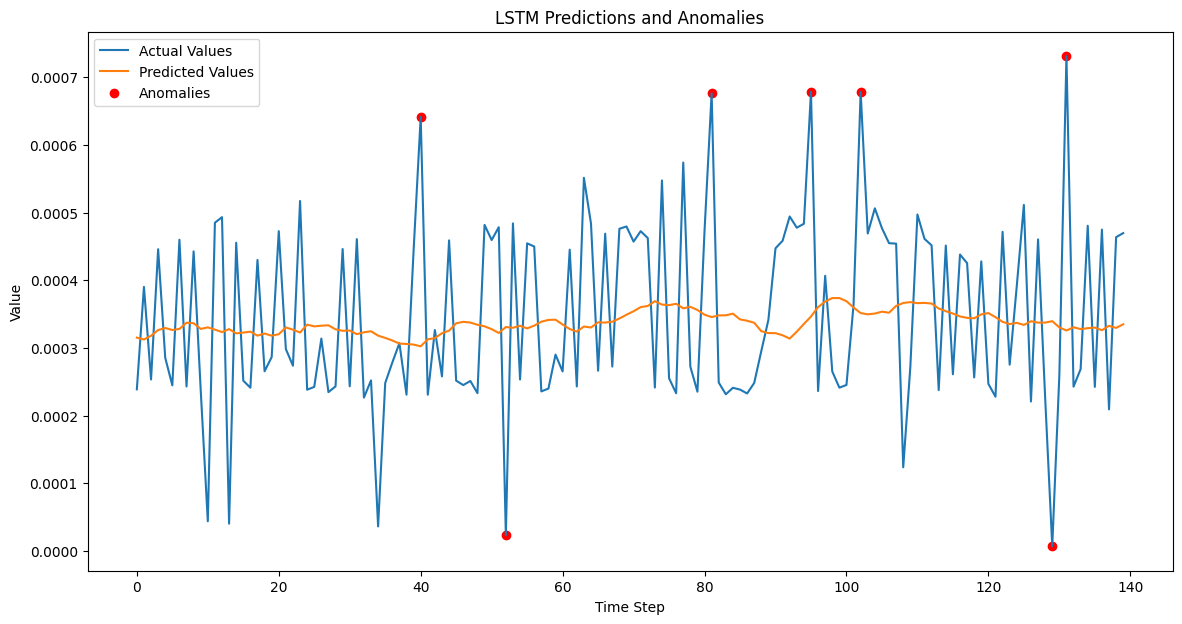

In [22]:
#LSTM Model[Array method error]

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split

# Load the data
file_path = '/content/scrape_duration_seconds.csv'
df = pd.read_csv(file_path)

# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Sort by time (just to ensure correct order)
df = df.sort_values(by='Time')

# Extract the 'Value' column for modeling
values = df['Value'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Parameters
SEQ_LENGTH = 10  # Sequence length (this can be tuned)

# Create sequences
X, y = create_sequences(values_scaled, SEQ_LENGTH)

# Reshape X to be compatible with LSTM (samples, time steps, features)
X = np.array(X).reshape((X.shape[0], X.shape[1], 1))

# Ensure y is also a numpy array
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model with Input layer
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, 1)))  # Use Input layer to define the shape
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get them back to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Print a few predictions and actual values
print("Predictions:", predictions_rescaled[:5].flatten())
print("Actual Values:", y_test_rescaled[:5].flatten())


import numpy as np
import matplotlib.pyplot as plt

# Calculate the absolute error between the predictions and the actual values
errors = np.abs(predictions_rescaled.flatten() - y_test_rescaled.flatten())

# Set a threshold for anomaly detection (e.g., 95th percentile of the errors)
threshold = np.percentile(errors, 95)

# Identify anomalies
anomalies = errors > threshold

# Print the number of anomalies found
print(f"Number of anomalies found: {np.sum(anomalies)}")

# Visualize the results
plt.figure(figsize=(14, 7))

plt.plot(y_test_rescaled.flatten(), label='Actual Values')
plt.plot(predictions_rescaled.flatten(), label='Predicted Values')
plt.scatter(np.where(anomalies)[0], y_test_rescaled[anomalies], color='red', label='Anomalies')

plt.title('LSTM Predictions and Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.6060 - val_loss: 0.5308
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5830 - val_loss: 0.5120
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5510 - val_loss: 0.4847
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5176 - val_loss: 0.4481
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4994 - val_loss: 0.3998
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4261 - val_loss: 0.3436
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3699 - val_loss: 0.2887
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3086 - val_loss: 0.2440
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2624 - val_loss: 0.2103
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2297 - val_loss: 0.1848
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2133 - val_loss: 0.1698
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1984 - val_loss: 0.1639
E

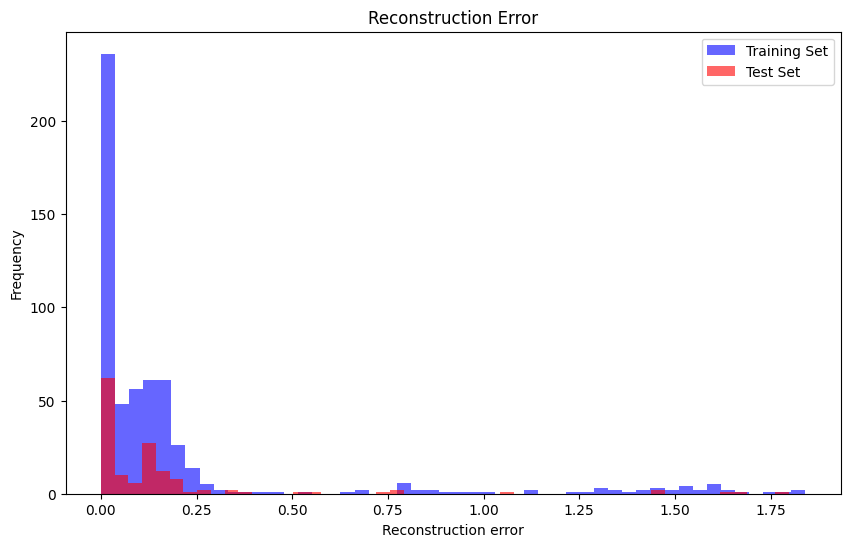

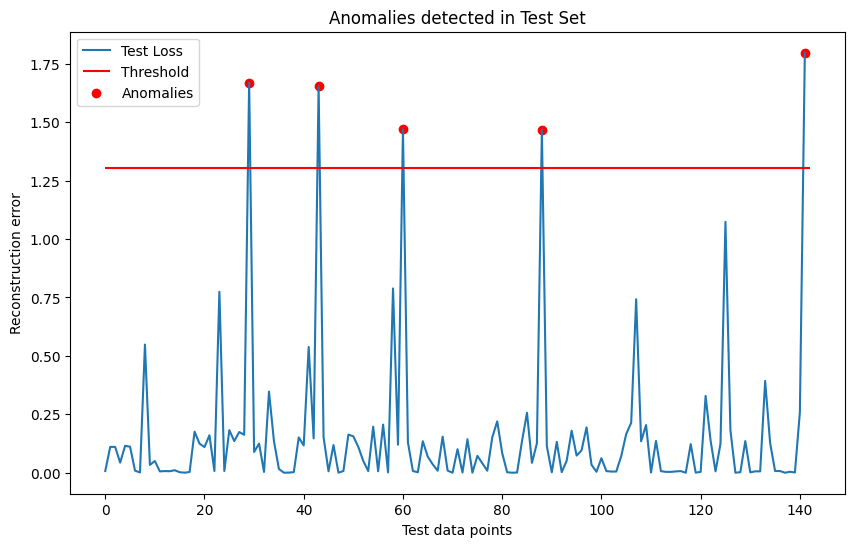

In [28]:
#Autoencoder

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models # Import layers from tensorflow.keras.layers
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('/content/scrape_duration_seconds.csv')

# Preprocessing
numerical_features = ['Value']
categorical_features = ['instance', 'job']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X = df[numerical_features + categorical_features]
X_preprocessed = preprocessor.fit_transform(X)

# Train-test split
# X_train, X_test = train_test_split(X_preprocessed, test_size=0.2, random_state=42)

X_train_dense, X_test_dense = train_test_split(X_preprocessed, test_size=0.2, random_state=42)

# Convert sparse to dense arrays if needed
# X_train_dense = X_train.toarray()
# X_test_dense = X_test.toarray()

# Autoencoder model
input_dim = X_train_dense.shape[1]
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(X_train_dense, X_train_dense,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_dense, X_test_dense))


# Predict on the training set and test set
train_predictions = autoencoder.predict(X_train_dense)
test_predictions = autoencoder.predict(X_test_dense)

# Calculate the reconstruction error for training and test sets
train_loss = np.mean(np.power(X_train_dense - train_predictions, 2), axis=1)
test_loss = np.mean(np.power(X_test_dense - test_predictions, 2), axis=1)

# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.title("Reconstruction Error")
plt.hist(train_loss, bins=50, alpha=0.6, color='blue', label='Training Set')
plt.hist(test_loss, bins=50, alpha=0.6, color='red', label='Test Set')
plt.legend()
plt.xlabel("Reconstruction error")
plt.ylabel("Frequency")
plt.show()

# Set a threshold for anomaly detection
threshold = np.percentile(train_loss, 95)  # for example, you can set it to the 95th percentile of the training loss

# Plot anomalies
anomalies = test_loss > threshold
plt.figure(figsize=(10, 6))
plt.plot(test_loss, label="Test Loss")
plt.hlines(threshold, 0, len(test_loss), colors='r', zorder=100, label="Threshold")
plt.scatter(np.where(anomalies)[0], test_loss[anomalies], color='r', marker='o', label="Anomalies")
plt.title("Anomalies detected in Test Set")
plt.xlabel("Test data points")
plt.ylabel("Reconstruction error")
plt.legend()
plt.show()
